In [1]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import torch
import math
import timm

import transforms.eft as Eft
from datasets.transformed_dataset import TransformedDataset
from utils import plot_confusion_matrix
from models.radio_rec_model import RadioRecNetwork
from models.resnet import create_resnet_2d, create_resnet_1d
from models.efficientnet import efficientnet_b0, efficientnet_b2, efficientnet_b4
import datasets.signal_file_dataset as sfds
import os.path

In [ ]:
import pytorch_lightning as pl
pl.__version__

In [ ]:
torch.__version__

In [ ]:
print(torch.cuda.is_available())

In [2]:
data_root_dir = "d:/data/duijiangji"
checkpoint_dir=f'./exp/radiorec/duijiangji-raw-iq-resnet18-checkpoints'

In [3]:
train_dir = os.path.join(data_root_dir, 'train')
train_file_set = sfds.SignalFileSet(train_dir, 'bin')
train_file_set.print_info()

test_dir = os.path.join(data_root_dir, 'test')
test_file_set = sfds.SignalFileSet(test_dir, 'bin')
test_file_set.print_info()

data path: d:/data/duijiangji\train
classes: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
{'A': 24, 'B': 24, 'C': 23}
data path: d:/data/duijiangji\test
classes: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
{'A': 10, 'B': 10, 'C': 10}


In [10]:
import datasets.signal_file_dataset as sfds
sig_file_conf = sfds.SignalFileConfig()
sig_file_conf.fs = 256000      # 64K Hz sample rate
sig_file_conf.seg_len = 50   # 200ms ???
sig_file_conf.seg_shift = 50 # 200 ms, no overlap
sig_file_conf.max_num = 4000
sig_file_conf.is_complex = True
sig_file_conf.energy_threshold = 1.0

train_dataset = sfds.SignalDataSet(train_file_set, sig_file_conf)
train_dataset.print_info()

test_dataset = sfds.SignalDataSet(test_file_set, sig_file_conf)
test_dataset.print_info()

class list: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
seg count for each class: {'A': 23150, 'B': 21997, 'C': 22707}
class list: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
seg count for each class: {'A': 9208, 'B': 9527, 'C': 9765}


In [11]:
train_dataset.save(os.path.join(data_root_dir, 'train_50ms.hdf5'))
test_dataset.save(os.path.join(data_root_dir, 'test_50ms.hdf5'))

In [12]:
train_dataset = sfds.SignalDataSet()
train_dataset.load(os.path.join(data_root_dir, 'train_50ms.hdf5'))
train_dataset.print_info()

test_dataset = sfds.SignalDataSet()
test_dataset.load(os.path.join(data_root_dir, 'test_50ms.hdf5'))
test_dataset.print_info()

class_list = train_dataset.class_list
num_classes = len(class_list)

class list: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
seg count for each class: {'A': 23150, 'B': 21997, 'C': 22707}
class list: ['A', 'B', 'C']
class dict: {'A': 0, 'B': 1, 'C': 2}
seg count for each class: {'A': 9208, 'B': 9527, 'C': 9765}


In [ ]:
train_dataset.data.shape

In [ ]:
train_dataset.labels.shape

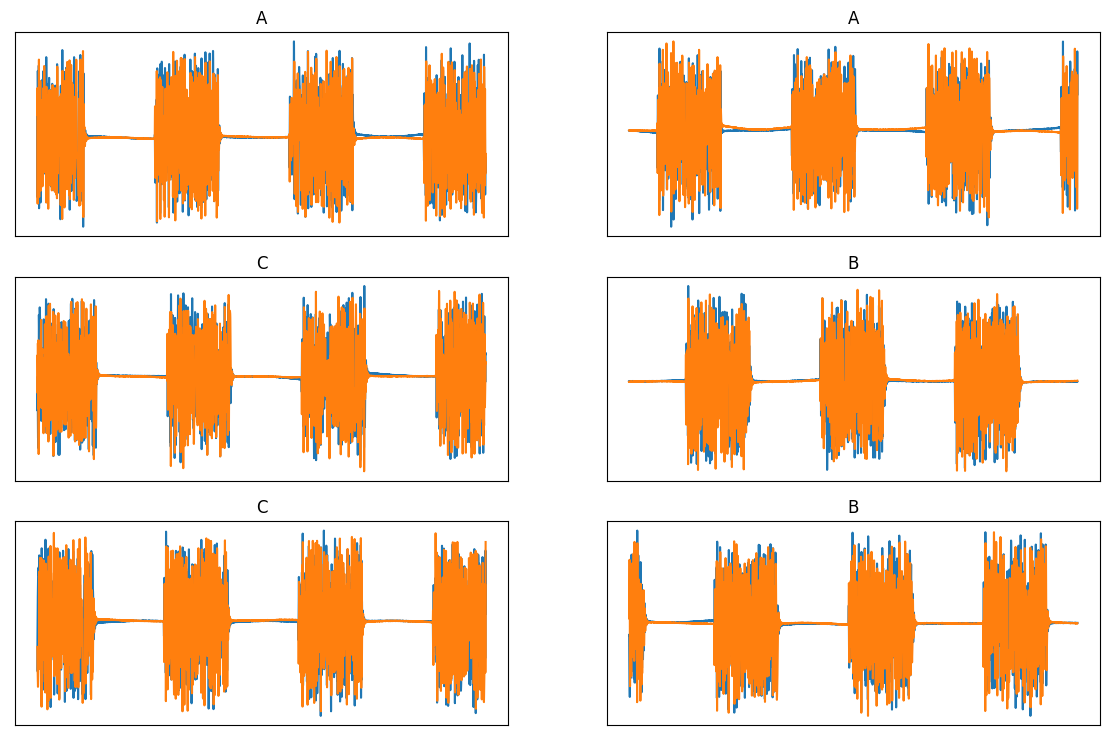

In [13]:
# Repeat but plot andom sampling of the data
from datasets.visualize import IQVisualizer

example_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=6,
    num_workers=0,
    shuffle=True,
    drop_last=True,
)
visualizer = IQVisualizer(
    data_loader = example_dataloader,
    visualize_target_transform = lambda target: [class_list[int(index)] for index in target]
)

for figure in iter(visualizer):
    figure.set_size_inches(14, 9)
    plt.show()
    break

In [14]:
from transforms.transforms import Compose
from transforms.spectrogram_transform import SpectrogramConfig, Spectrogram
from transforms.impairment import Normalize, AddNoise, SpectrogramPatchShuffle, RandomPhaseShift

interleave_to_complex = Eft.InterleaveComplex()

random_phase_shift = RandomPhaseShift(phase_offset=(-1, 1))

add_noise = AddNoise((-40, -20)) # Added AWGN power range is (-40, -20) dB

normalize_transform = Normalize(norm=2)

#spectrogram_config = SpectrogramConfig()
#spectrogram_config.nperseg = 256
#spectrogram_config.noverlap = 128
#spectrogram_config.nfft = 256
#spectrogram_config.window = 'hann'
#spectrogram_config.return_onesided = False
#spectrogram_config.mode = 'magnitude'
#spectorgram_transform = Spectrogram(spectrogram_config)
#spec_patch_shuffle = SpectrogramPatchShuffle(patch_size=(2,16), shuffle_ratio=(0.01,0.10))

complex_to_2d = Eft.ComplexTo2D()
train_transform = Compose([interleave_to_complex, random_phase_shift, add_noise, normalize_transform, complex_to_2d])
train_dataset = TransformedDataset(train_dataset, transform = train_transform)

test_transform = Compose([interleave_to_complex, normalize_transform, complex_to_2d])
test_dataset = TransformedDataset(test_dataset, transform = test_transform)


In [15]:
num = len(test_dataset)
num_test = math.floor(0.5 * num)
num_val = num - num_test

test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [num_test, num_val],
                                                                         generator = torch.Generator().manual_seed(42))
idx = np.random.randint(len(test_dataset))
data, label = test_dataset[idx]
channels = data.shape[0]
print("Train dataset length: {}".format(len(train_dataset)))
print("Val dataset length: {}".format(len(val_dataset)))
print("Test dataset length: {}".format(len(test_dataset)))

print("Data shape: {}".format(data.shape))
print(f"Channels: {channels}")
print("Label Index: {}".format(label))
print("Label Class: {}".format(class_list[label]))

Train dataset length: 67854
Val dataset length: 14250
Test dataset length: 14250
Data shape: (2, 12800)
Channels: 2
Label Index: 0
Label Class: A


In [16]:
# ----
# ### Format Dataset for Training
# Next, the datasets are then wrapped as `DataLoaders` to prepare for training.

# Create dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    num_workers=0,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=8,
    num_workers=0,
    shuffle=False,
    drop_last=True,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    num_workers=0,
    shuffle=False,
    drop_last=False,
)

In [17]:
# model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
model = create_resnet_1d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
# model = efficientnet_b0(num_classes = num_classes)
model

ResNet(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [19]:
# Training Config
learning_rate=0.002
epochs = 10

radiorec_model = RadioRecNetwork(model, learning_rate = learning_rate)

In [20]:
# ----
# ### Train the Model
# To train the model, we first create a `ModelCheckpoint` to monitor the validation loss over time and save the best model as we go. The network is then instantiated and passed into a `Trainer` to kick off training.
import os

if not os.path.exists(checkpoint_dir):
    print(f'mkdir: {checkpoint_dir}')
    os.makedirs(checkpoint_dir)

In [21]:
# Setup checkpoint callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename='{epoch}-{val_loss:.2f}',
    save_top_k=3,
    save_last=True,
    verbose=True,
    monitor="val_loss",
    mode="min",
)

In [ ]:
# Create and fit trainer

trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, devices=1, accelerator="gpu"
)

trainer.fit(radiorec_model, train_dataloaders=train_dataloader, val_dataloaders = val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory D:\radiorec\exp\radiorec\duijiangji-raw-iq-resnet18-checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | mdl  | ResNet | 3.9 M 
--------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.403    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

D:\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\anaconda3\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 8481: 'val_loss' reached 1.06170 (best 1.06170), saving model to 'D:\\radiorec\\exp\\radiorec\\duijiangji-raw-iq-resnet18-checkpoints\\epoch=0-val_loss=1.06.ckpt' as top 3


In [ ]:
checkpoint_callback.best_model_path

In [ ]:
# After the model is trained, the checkpoint's weights are loaded into the model and the model is put into evaluation mode. The validation set is looped through, inferring results for each example and saving the predictions and the labels. Finally, the labels and predictions are passed into our confusion matrix plotting function to view the results and also passed into the `sklearn.metrics.classification_report` method to print metrics of interest.
checkpoint_filename = checkpoint_callback.best_model_path

# Load best checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(
    checkpoint_filename, map_location=lambda storage, loc: storage
)

# model = create_resnet_2d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
# model = create_resnet_1d(name = 'resnet18', pretrained = False, num_classes = num_classes, in_chans = channels)
model = efficientnet_b0(num_classes = num_classes)

test_model = RadioRecNetwork(model, learning_rate = learning_rate)
test_model.load_state_dict(checkpoint["state_dict"])
test_model = test_model.to(device=device).eval()

In [ ]:
# ### Evaluate the val set

# Infer results over validation set
num_val_examples = len(val_dataset)
y_raw_preds = np.empty((num_val_examples, num_classes))
y_preds = np.zeros((num_val_examples,))
y_true = np.zeros((num_val_examples,))

for i in tqdm(range(0, num_val_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = val_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

In [ ]:
acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Validation Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/val_result.png")

print("Val set classification report:")
print(classification_report(y_true, y_preds))

In [ ]:
# ----
# ### Evaluate the test set

# Infer results over validation set
num_test_examples = len(test_dataset)
y_raw_preds = np.empty((num_test_examples, num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0, num_test_examples)):
    # Retrieve data
    idx = i  # Use index if evaluating over full dataset
    data, label = test_dataset[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data, 0)).float().to(device)
    pred_tmp = test_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

acc = np.sum(np.asarray(y_preds) == np.asarray(y_true)) / len(y_true)
plot_confusion_matrix(
    y_true,
    y_preds,
    classes = class_list,
    normalize = True,
    title="Test Set Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(
        acc * 100
    ),
    text=False,
    rotate_x_text=90,
    figsize=(16, 9),
)
plt.savefig(f"{checkpoint_dir}/test_result.png")

print("Test set classification report:")
print(classification_report(y_true, y_preds))